# Coffee shop business in Syndey CBD and surrounding Suburbs




## A. Introduction 

### Description of the business problem
According to statista, Australia coffee market is among the largest in the world, reaching a revenue greater than 1.4 Billion US dollars in 2017. Futhermore, Australians consumed around 1.91 kilograms of coffee per person in 2019 on average. In particular, residents in Sydney are more inclined to purchase fresh coffee based on a research published by Roy Morgan Single Source. As a result, this represents lucurative opportunities for entrepreneurs who would like to establish their coffee shop business in Sydney

The purpose of this report is to help potential entrepreneurs in Sydney who wish to set up their own coffee shop. This report will provide them with insights on the optimal location that they can consider in establishing their coffee business. The results of this report will be present in a map, where each suburb is represented by ciricle dot based on the nearby venues within this suburb

### Data Description

In order to approach the problem, I have extracted relevant datas by the following ways:

1. I have utilized requests and Beautiful Soup package to scrape the wikipedia page of Sydney CBD (Sydney City Centre) and its surrounding suburbs to obtain the latitude and longitude of each location respectively

2. I have relied on **Foursqaure API** to obtain the most common venues of each suburb 


## B. Methodology

 

In [1]:
import requests
import bs4
import pandas as pd
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from dms2dec.dms_convert import dms2dec
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium # map rendering library


CLIENT_ID = 'OOL3CJVWOLDGNU01D1VMCWKV2M1MQN5EJVXO13BBHWZPKGYR' # your Foursquare ID
CLIENT_SECRET = 'VZWPT2ARYG2CTCL1QSUTIUM2B5MFIIH4HOEJUGSUN15CXM3U' # your Foursquare Secret
ACCESS_TOKEN = 'KEZAPAWX2SID04SJG51EVSH5332ZQX1OXTFXMNEIYPWB2TBU' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100 # A default Foursquare API limit value

In [2]:
result = requests.get('https://en.wikipedia.org/wiki/Sydney_central_business_district').text # Using BeatifulSoup to scrape the Syndey Business district 
soup = bs4.BeautifulSoup(result, 'lxml') 

In [3]:
suburbs_dictionary = {}  # Use dictionary to store the details of the Suburb


In [4]:
for info in soup.find_all('tr', class_ = 'mergedrow'):   # Extract Sydney Central Business Distrcit nearby Suburb
    for info in info.find_all('td'):
            if info.text == 'Sydney City Centre':
                 suburbs_dictionary[info.text] = {} 
                
            else:
                if info.a.text == 'Suburbs':
                    pass
                
                else:
                    for info in info.find_all('a'):
                       suburbs_dictionary[info.text] = {}
                    
del suburbs_dictionary['Port Jackson']

suburbs_dictionary


{'Barangaroo': {},
 'Millers Point': {},
 'The Rocks': {},
 'Pyrmont': {},
 'Sydney City Centre': {},
 'Woolloomooloo': {},
 'Darlinghurst': {},
 'Ultimo': {},
 'Haymarket': {},
 'Surry Hills': {}}

In [5]:
#def getcoordinate(suburbs):  #Web Scrape different suburb pages
    
for suburb in suburbs_dictionary:      
                    
            url = 'https://en.wikipedia.org/wiki/{},_New_South_Wales'.format(suburb)        
            result1 = requests.get(url).text    
            
            
            if  'Wikipedia does not have an article with this exact name' in result1: 
               result1 = requests.get('https://en.wikipedia.org/wiki/Sydney_central_business_district').text
                                          
            else:
                 pass
                
            soup = bs4.BeautifulSoup(result1, 'lxml')
            info = soup.find('span', class_ = 'geo-default') 
            
            try:
               
                latitude = round(dms2dec(info.find('span', class_ = 'latitude').text),4)
                longitude = round(dms2dec(info.find('span', class_ = 'longitude').text),4)
                
            except:
                
                latitude = -(float(info.find('span', class_ = 'geo-dec').text.split()[0].strip('°S')))
                longitude = float(info.find('span', class_ = 'geo-dec').text.split()[1].strip('°E'))
               
                    
            suburbs_dictionary[suburb]['latitude'] = latitude
            suburbs_dictionary[suburb]['longitude'] = longitude


In [6]:
suburbs_dictionary 


{'Barangaroo': {'latitude': -33.8611, 'longitude': 151.203},
 'Millers Point': {'latitude': -33.8608, 'longitude': 151.2028},
 'The Rocks': {'latitude': -33.85985, 'longitude': 151.20901},
 'Pyrmont': {'latitude': -33.875, 'longitude': 151.1964},
 'Sydney City Centre': {'latitude': -33.8681, 'longitude': 151.2122},
 'Woolloomooloo': {'latitude': -33.8703, 'longitude': 151.2222},
 'Darlinghurst': {'latitude': -33.8833, 'longitude': 151.225},
 'Ultimo': {'latitude': -33.8822, 'longitude': 151.1969},
 'Haymarket': {'latitude': -33.8808, 'longitude': 151.2031},
 'Surry Hills': {'latitude': -33.8861, 'longitude': 151.2111}}

## B. Methodology

I have create a dataframe to store the **name of Suburb** as well as its **longitude** and **latitude** 

In [7]:
columns = ['Suburb', 'latitude', 'longitude']
sydney_data = pd.DataFrame(columns = columns)

for suburb in suburbs_dictionary:
 
    latitude = str(suburbs_dictionary[suburb]['latitude'])
    longitude = str(suburbs_dictionary[suburb]['longitude']) 
    sydney_data = sydney_data.append({'Suburb':suburb, 'latitude': latitude, 'longitude': longitude}, ignore_index=True)
    
sydney_data


,Suburb,latitude,longitude
0,Barangaroo,-33.8611,151.203
1,Millers Point,-33.8608,151.2028
2,The Rocks,-33.85985,151.20901
3,Pyrmont,-33.875,151.1964
4,Sydney City Centre,-33.8681,151.2122
5,Woolloomooloo,-33.8703,151.2222
6,Darlinghurst,-33.8833,151.225
7,Ultimo,-33.8822,151.1969
8,Haymarket,-33.8808,151.2031
9,Surry Hills,-33.8861,151.2111


### B1: Retrieving venues and related information of each suburb from FourSquare API by using the following function

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
   
    venues_list = []    
    for name, lat, lng in zip(names, latitudes, longitudes):   
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([( 
            name,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
new_sydney_data = getNearbyVenues(sydney_data['Suburb'],sydney_data['latitude'], sydney_data['longitude'],500)

new_sydney_data

,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barangaroo,-33.8611,151.203,The Langham Hotel Sydney,-33.860517,151.203437,Hotel
1,Barangaroo,-33.8611,151.203,Sydney Observatory,-33.859534,151.204643,Planetarium
2,Barangaroo,-33.8611,151.203,Observatory Hill,-33.859125,151.204977,Park
3,Barangaroo,-33.8611,151.203,CAVA,-33.862581,151.204053,Coffee Shop
4,Barangaroo,-33.8611,151.203,Lord Nelson Brewery Hotel,-33.858403,151.203548,Brewery
...,...,...,...,...,...,...,...
652,Surry Hills,-33.8861,151.2111,Aurora Hotel,-33.884275,151.208389,Pub
653,Surry Hills,-33.8861,151.2111,Juice & Java Lounge,-33.889238,151.207980,Coffee Shop
654,Surry Hills,-33.8861,151.2111,Emad's Restaurant,-33.890053,151.208820,Lebanese Restaurant
655,Surry Hills,-33.8861,151.2111,Central Station,-33.883940,151.206912,Train Station


I have utilized the **folium** library to illustrate the suburbs that are concerned in this analysis. The suburbs are shown as below with each blue dot represented one suburb

In [10]:
address = 'Sydney CBD'

geolocator = Nominatim(user_agent="Syndey")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
#print('The geograpical coordinate of Sydney CBD are {}, {}.'.format(latitude, longitude))

map_clusters = folium.Map(location = [latitude, longitude], zoom_start=13)



# add markers to the map
markers_colors = []
for lat, lon  in zip(new_sydney_data['Suburb Latitude'], new_sydney_data['Suburb Longitude']):
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        color='blue',
        fill=True,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Based on the information retrieved from Foursquare API, I have summarized the **number of veneues** with a radius of **500 meter** for each suburbs with respect to their latitude and longitudes provided the **new_sydney_data** dataframe and the results is visualized in the bar chart below

In [11]:
venue_data = new_sydney_data.groupby(['Suburb','Venue']).size().reset_index(name='Counts')
venue_data = venue_data.groupby('Suburb').sum()
venue_data

,Counts
Suburb,
Barangaroo,40
Darlinghurst,42
Haymarket,63
Millers Point,40
Pyrmont,68
Surry Hills,85
Sydney City Centre,71
The Rocks,100
Ultimo,53


Text(0, 0.5, 'Counts')

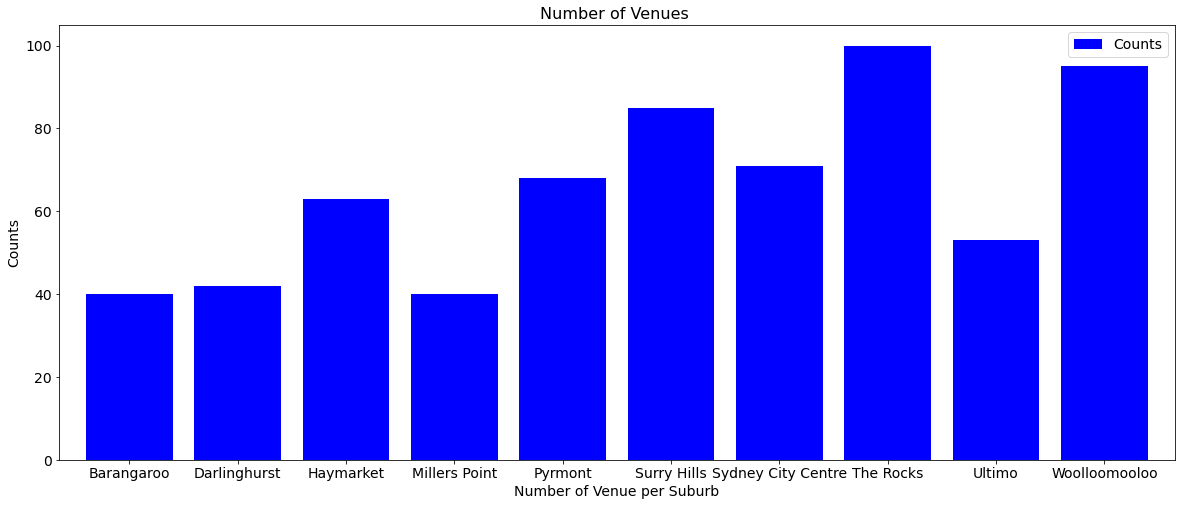

In [12]:
venue_data.plot(kind='bar',figsize=(20,8),width = 0.8, color='blue')
plt.legend(labels=venue_data.columns,fontsize= 14)
plt.title("Number of Venues ",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.yticks(fontsize=14)
plt.xlabel('Number of Venue per Suburb', fontsize=14)
plt.ylabel('Counts', fontsize=14)

### B2: Analyze each Suburb based on the venue's data 

In [13]:
sydney_onehot = pd.get_dummies(new_sydney_data[['Venue Category']], prefix='', prefix_sep = '')
sydney_onehot['Suburb'] = new_sydney_data['Suburb']
#sydney_onehot.rename(columns={'Suburb':'Suburb Venue' })

fixed_columns = [sydney_onehot.columns[-1]] + list(sydney_onehot.columns[:-1])
sydney_onehot = sydney_onehot[fixed_columns]

sydney_onehot.head()

,Suburb,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,...,Theme Restaurant,Tour Provider,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Xinjiang Restaurant,Yoga Studio
0,Barangaroo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Barangaroo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Barangaroo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Barangaroo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Barangaroo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Next, let's group rows by borough and by taking the mean of the frequency of occurrence of each category

In [14]:
sydney_grouped = sydney_onehot.groupby('Suburb').mean().reset_index()

In [15]:
sydney_grouped.tail() 

,Suburb,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,...,Theme Restaurant,Tour Provider,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Xinjiang Restaurant,Yoga Studio
5,Surry Hills,0.011765,0.011765,0.011765,0.00,0.011765,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00,0.000000,0.011765,0.0,0.023529,0.035294,0.000000,0.0,0.023529
6,Sydney City Centre,0.000000,0.000000,0.014085,0.00,0.000000,0.000000,0.000000,0.014085,0.000000,...,0.0,0.00,0.000000,0.014085,0.0,0.014085,0.000000,0.000000,0.0,0.000000
7,The Rocks,0.000000,0.000000,0.000000,0.01,0.000000,0.010000,0.060000,0.000000,0.000000,...,0.0,0.01,0.010000,0.000000,0.0,0.000000,0.000000,0.010000,0.0,0.000000
8,Ultimo,0.018868,0.000000,0.018868,0.00,0.000000,0.000000,0.018868,0.000000,0.000000,...,0.0,0.00,0.000000,0.000000,0.0,0.018868,0.000000,0.000000,0.0,0.000000
9,Woolloomooloo,0.000000,0.000000,0.021053,0.00,0.000000,0.010526,0.052632,0.000000,0.010526,...,0.0,0.00,0.021053,0.000000,0.0,0.021053,0.000000,0.021053,0.0,0.000000


In [16]:
def return_most_common_venue(row, num_top_venues):  
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
   
    return row_categories_sorted.index.values[0:num_top_venues]
    
    



In [17]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']
columns = ['Suburb']

for ind in np.arange(sydney_grouped.shape[0]):
    try:
        columns.append('{}{} most common venue'.format(ind+1, indicators[ind]))
    
    except:     
        columns.append('{}th most common venue'.format(ind+1))
        
sydney_venue_sorted = pd.DataFrame(columns=columns)
sydney_venue_sorted['Suburb'] = sydney_grouped['Suburb']

for ind in np.arange(sydney_grouped.shape[0]):
   sydney_venue_sorted.iloc[ind, 1:] = return_most_common_venue(sydney_grouped.iloc[ind,: ], num_top_venues)
   

In [18]:
sydney_venue_sorted 

,Suburb,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
0,Barangaroo,Hotel,Café,Pub,Coffee Shop,Seafood Restaurant,Park,Hotel Bar,Chinese Restaurant,Restaurant,Performing Arts Venue
1,Darlinghurst,Café,Bar,Italian Restaurant,Pizza Place,Pub,Boutique,Indian Restaurant,Australian Restaurant,Pedestrian Plaza,Park
2,Haymarket,Thai Restaurant,Japanese Restaurant,Chinese Restaurant,Korean BBQ Restaurant,Café,Coffee Shop,Hostel,Hotel,Hotpot Restaurant,Malay Restaurant
3,Millers Point,Café,Hotel,Pub,Coffee Shop,Seafood Restaurant,Park,Planetarium,Chinese Restaurant,Restaurant,Plaza
4,Pyrmont,Café,Seafood Restaurant,Pub,Australian Restaurant,Fish Market,Hotel,Park,Grocery Store,Coffee Shop,Gym / Fitness Center
5,Surry Hills,Café,Coffee Shop,Pub,Pizza Place,Vietnamese Restaurant,Lebanese Restaurant,Japanese Restaurant,Sandwich Place,Karaoke Bar,Indian Restaurant
6,Sydney City Centre,Café,Coffee Shop,Hotel,Dessert Shop,Steakhouse,Restaurant,Sandwich Place,French Restaurant,Fountain,Chocolate Shop
7,The Rocks,Café,Hotel,Australian Restaurant,Pub,Hotel Bar,Cocktail Bar,Park,Sandwich Place,Chinese Restaurant,Coffee Shop
8,Ultimo,Café,Coffee Shop,Supermarket,Bar,Hotel,Ice Cream Shop,Kebab Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Italian Restaurant
9,Woolloomooloo,Café,Hotel,Australian Restaurant,Italian Restaurant,Pub,Coffee Shop,Hostel,Bar,Vegetarian / Vegan Restaurant,Supermarket


In [19]:
sydney_group_clustering = sydney_grouped.drop('Suburb', 1)

sydney_group_clustering 

,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Theme Restaurant,Tour Provider,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Xinjiang Restaurant,Yoga Studio
0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.025000,0.000000,0.000000,0.025000,...,0.000000,0.00,0.000000,0.000000,0.025,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.023810,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000,0.000000,0.023810,0.023810,0.000000,0.023810
2,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000,0.000000,0.015873,0.000000,0.015873,0.000000
3,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.025000,0.000000,0.000000,0.025000,...,0.000000,0.00,0.000000,0.000000,0.025,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.044118,0.000000,0.000000,0.000000,...,0.014706,0.00,0.000000,0.000000,0.000,0.000000,0.014706,0.000000,0.000000,0.000000
5,0.011765,0.011765,0.011765,0.00,0.011765,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.011765,0.000,0.023529,0.035294,0.000000,0.000000,0.023529
6,0.000000,0.000000,0.014085,0.00,0.000000,0.000000,0.000000,0.014085,0.000000,0.014085,...,0.000000,0.00,0.000000,0.014085,0.000,0.014085,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.01,0.000000,0.010000,0.060000,0.000000,0.000000,0.020000,...,0.000000,0.01,0.010000,0.000000,0.000,0.000000,0.000000,0.010000,0.000000,0.000000
8,0.018868,0.000000,0.018868,0.00,0.000000,0.000000,0.018868,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000,0.018868,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.021053,0.00,0.000000,0.010526,0.052632,0.000000,0.010526,0.000000,...,0.000000,0.00,0.021053,0.000000,0.000,0.021053,0.000000,0.021053,0.000000,0.000000


### B.3. Cluster of Suburbs
K-Means algorithm is one of the most common cluster method of unsupervised learning. I will use **K-Means algorithm** for my study in this project.

First, I will identify the **optimal number of clusters** to conduct this analysis based on the **elbow method**. Next, I will run the K-Means algorithm to group suburbs into different clusters based on theeir similarities

In [20]:
Sum_of_squared_distances = []
K = range(1,6)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(sydney_group_clustering)
    Sum_of_squared_distances.append(km.inertia_)

In [21]:
Sum_of_squared_distances

[0.18295516068889847,
 0.1383199046290159,
 0.0981795280130114,
 0.07084278492148334,
 0.052266414928145724]

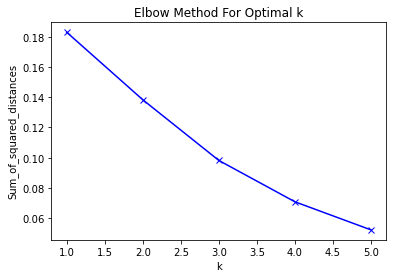

In [37]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [23]:
Kclusters = 3
Kmeans = KMeans(n_clusters = Kclusters, random_state = 0).fit(sydney_group_clustering)

In [24]:
sydney_venue_sorted.insert(0, 'Cluster Labels', Kmeans.labels_)
sydney_merged = sydney_data

In [25]:
sydney_merged = sydney_data.join(sydney_venue_sorted.set_index('Suburb'), on = 'Suburb')

 a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [26]:
sydney_merged

,Suburb,latitude,longitude,Cluster Labels,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
0,Barangaroo,-33.8611,151.203,1,Hotel,Café,Pub,Coffee Shop,Seafood Restaurant,Park,Hotel Bar,Chinese Restaurant,Restaurant,Performing Arts Venue
1,Millers Point,-33.8608,151.2028,1,Café,Hotel,Pub,Coffee Shop,Seafood Restaurant,Park,Planetarium,Chinese Restaurant,Restaurant,Plaza
2,The Rocks,-33.85985,151.20901,1,Café,Hotel,Australian Restaurant,Pub,Hotel Bar,Cocktail Bar,Park,Sandwich Place,Chinese Restaurant,Coffee Shop
3,Pyrmont,-33.875,151.1964,1,Café,Seafood Restaurant,Pub,Australian Restaurant,Fish Market,Hotel,Park,Grocery Store,Coffee Shop,Gym / Fitness Center
4,Sydney City Centre,-33.8681,151.2122,1,Café,Coffee Shop,Hotel,Dessert Shop,Steakhouse,Restaurant,Sandwich Place,French Restaurant,Fountain,Chocolate Shop
5,Woolloomooloo,-33.8703,151.2222,1,Café,Hotel,Australian Restaurant,Italian Restaurant,Pub,Coffee Shop,Hostel,Bar,Vegetarian / Vegan Restaurant,Supermarket
6,Darlinghurst,-33.8833,151.225,0,Café,Bar,Italian Restaurant,Pizza Place,Pub,Boutique,Indian Restaurant,Australian Restaurant,Pedestrian Plaza,Park
7,Ultimo,-33.8822,151.1969,0,Café,Coffee Shop,Supermarket,Bar,Hotel,Ice Cream Shop,Kebab Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Italian Restaurant
8,Haymarket,-33.8808,151.2031,2,Thai Restaurant,Japanese Restaurant,Chinese Restaurant,Korean BBQ Restaurant,Café,Coffee Shop,Hostel,Hotel,Hotpot Restaurant,Malay Restaurant
9,Surry Hills,-33.8861,151.2111,0,Café,Coffee Shop,Pub,Pizza Place,Vietnamese Restaurant,Lebanese Restaurant,Japanese Restaurant,Sandwich Place,Karaoke Bar,Indian Restaurant


In [27]:
address = 'Sydney CBD'

geolocator = Nominatim(user_agent="Syndey")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Sydney CBD are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Sydney CBD are -33.8679574, 151.210047.


In [28]:
# create map
map_clusters = folium.Map(location = [latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(Kclusters)
ys = [i + x + (i*x)**2 for i in range(Kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)+2))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(sydney_merged['latitude'], sydney_merged['longitude'], sydney_merged['Cluster Labels']):
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We can interrupt the above map as follows:

Cluster Red : **Barangaroo** and **Millers Point**

Cluster Purple : **The Rocks**, **Pyrmont**, **Sydney City Centre**, **Woolloomooloo**, **Darlinghurst**,**Ultimo** and **Surry Hills**

Cluster Blue : **Haymarket**

In [29]:
count_venue = sydney_merged
count_venue = count_venue.drop(['Suburb', 'latitude', 'longitude'], axis=1)
count_venue = count_venue.groupby(['Cluster Labels','1st most common venue']).size().reset_index(name='Counts') #Specify name of new column
#we can transpose it to plot bar chart
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st most common venue', values='Counts') 
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st most common venue,Café,Hotel,Thai Restaurant
0,3,0,0
1,5,1,0
2,0,0,1


We can also examine the number of **1st Most Common Venue** in each cluster and the results are presented in the bar chart below

Text(0, 0.5, 'Number of Venues')

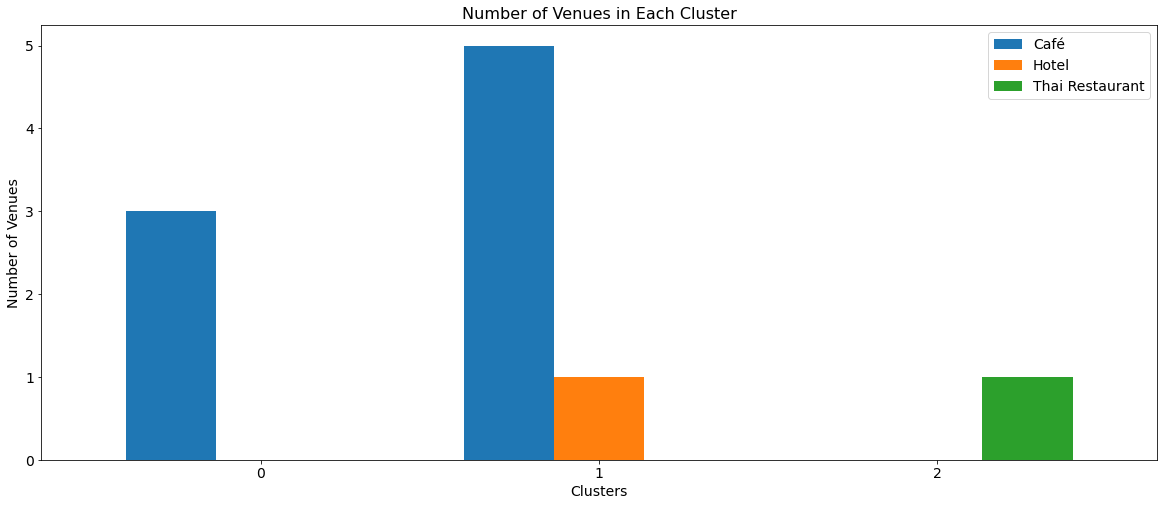

In [30]:
frame=cv_cluster.plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=cv_cluster.columns,fontsize= 14)
plt.title("Number of Venues in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.yticks(fontsize=14)
plt.xlabel('Clusters', fontsize=14)
plt.ylabel('Number of Venues', fontsize=14)